# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 


### Problem Statement / Metrics

_1. Which demographic groups respond best to which offer type?_
_2. Which model help to predict whether a customer will complete a offer by making transaction after viewing the offer?_


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## 1. Importing libraries and Reading Dataset


In [496]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [497]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [498]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [499]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## 2. Data Wrangling

In [500]:
# function to check duplicates
def check_duplicates(df):
    for col in df.columns:
        if type(df[col][0]) is not list and type(df[col][0]) is not dict:
            print('{} duplicates: {}'.format(col, df.duplicated(col).sum()))

In [501]:
# function to check null values
def check_null(df):
    total = len(df)
    for col in df.columns:
        nan_rows = df[col].isnull().sum()
        print('{} has {} % of null values'.format(col, (nan_rows/total)*100))

In [502]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [503]:
len(portfolio)

10

In [504]:
check_duplicates(portfolio)

reward duplicates: 5
difficulty duplicates: 5
duration duplicates: 5
offer_type duplicates: 7
id duplicates: 0


In [505]:
check_null(portfolio)

reward has 0.0 % of null values
channels has 0.0 % of null values
difficulty has 0.0 % of null values
duration has 0.0 % of null values
offer_type has 0.0 % of null values
id has 0.0 % of null values


In [506]:
len(portfolio.id.unique())

10

In [507]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

__From here we can see that no duplicate Id or null values found on response. In total 10 portfolio exist with following offer type:__
_1. 4 of By One Get One(bogo),<br>_
_2. 4 of discount,<br>_
_3. 3 of informational._

In [508]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [509]:
len(profile)

17000

In [510]:
check_duplicates(profile)

gender duplicates: 16996
age duplicates: 16915
id duplicates: 0
became_member_on duplicates: 15284
income duplicates: 16908


In [511]:
check_null(profile)

gender has 12.794117647058822 % of null values
age has 0.0 % of null values
id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 12.794117647058822 % of null values


In [512]:
len(profile.id.unique())

17000

__From here we can see that we have not found duplicate customer ID, whereas we can see ~12.8% of null values incase of Gender and Income.__
_In this we will conclude to remove those null value from Gender and Income_

In [513]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [514]:
len(transcript)

306534

In [515]:
check_duplicates(transcript)

person duplicates: 289534
event duplicates: 306530
time duplicates: 306414


In [516]:
len(transcript.person.unique())

17000

In [517]:
check_null(transcript)

person has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values


_From this we can see that customer in transcipt and profile are having same unique ID. In this case, best possible solution will be to combine porfile and transcipt dataframe according to customer ID._

In [518]:
profile = profile.rename(columns = {'id':'customer_id'})

In [519]:
profile.head(1)

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


In [520]:
transcript = transcript.rename(columns = {'person':'customer_id'})

In [521]:
transcript.head(1)

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [522]:
temp_comb = pd.merge(profile, transcript, on='customer_id')

In [523]:
temp_comb.head()

,gender,age,customer_id,became_member_on,income,event,value,time
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
1,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216
2,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
3,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348
4,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,transaction,{'amount': 0.35000000000000003},360


In [524]:
check_duplicates(temp_comb)

gender duplicates: 306530
age duplicates: 306449
customer_id duplicates: 289534
became_member_on duplicates: 304818
income duplicates: 306442
event duplicates: 306530
time duplicates: 306414


In [525]:
len(temp_comb)

306534

In [526]:
check_null(temp_comb)

gender has 11.017374907840566 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 11.017374907840566 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values


In [527]:
len(temp_comb.customer_id.unique())

17000

_From this we can see that after combining dataframe 17000 are unique customers are available but in that ~11% data are having null value in gender and income. So lets remove those null values._

In [528]:
temp_comb = temp_comb.dropna(axis=0, subset=['gender'])

In [529]:
check_null(temp_comb)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values


In [530]:
len(temp_comb)

272762

In [531]:
len(temp_comb.customer_id.unique())

14825

In [532]:
temp_comb.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time
21,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18
22,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144


In [533]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [534]:
temp_comb.reset_index(drop=True, inplace=True)

In [535]:
temp_comb.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144


In [536]:
temp_comb=pd.concat([temp_comb, temp_comb['value'].apply(pd.Series)], axis=1)

In [537]:
temp_comb.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,offer id,offer_id,reward
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,NaN


In [538]:
temp_comb.reward.value_counts()

5.0     11677
2.0      8914
10.0     6967
3.0      4886
Name: reward, dtype: int64

In [539]:
temp_comb['offer_id_new']=np.where(temp_comb['offer id'].isnull() & temp_comb['offer_id'].notnull(),temp_comb['offer_id'],temp_comb['offer id'])

#drop unnecessary offer_id columns
temp_comb.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
temp_comb.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [540]:
temp_comb.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN


In [541]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [542]:
temp2 = temp_comb

In [543]:
temp2.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN


In [544]:
portfolio = portfolio.rename(columns = {'id':'offer_id'})

In [545]:
temp2['offer_type'] = 'None'

In [546]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None


In [547]:
temp2.shape

(272762, 12)

In [548]:
portfolio_offer_id = portfolio['offer_id'].tolist()    

In [549]:
portfolio_offer_id

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '3f207df678b143eea3cee63160fa8bed',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '5a8bc65990b245e5a138643cd4eb9837',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2906b810c7d4411798c6938adc9daaa5']

In [550]:
'ae264e3637204a6fb9bb56bc8210ddfd' in portfolio_offer_id

True

In [551]:
portfolio[portfolio['offer_id']=='ae264e3637204a6fb9bb56bc8210ddfd'].index.values[0]

0

In [552]:
temp2['offer_id'].values[0]

nan

In [553]:
temp2['duration'] = 0

In [554]:
temp2['difficulty'] = 0

In [555]:
temp2['reward_new'] = 0

In [556]:
temp2.shape

(272762, 15)

In [557]:
temp2.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0


In [558]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [559]:
from progressbar import ProgressBar

In [560]:
type(portfolio['channels'].values[0])

list

In [561]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,0,0,0
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None,0,0,0
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0


In [562]:
temp2['channels'] = [list() for x in range(len(temp2.index))]

In [563]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,0,0,0,[]
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None,0,0,0,[]
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0,[]


In [564]:
pbar = ProgressBar()
for row in pbar(range(272762)):
    current_offer = temp2['offer_id'].values[row]
    if current_offer in portfolio_offer_id:
        ind = portfolio[portfolio['offer_id']==current_offer].index.values[0]
        temp2.at[row,'offer_type']= portfolio['offer_type'].values[ind]
        temp2.at[row,'duration']= portfolio['duration'].values[ind]
        temp2.at[row,'difficulty']= portfolio['difficulty'].values[ind]
        temp2.at[row,'channels']= portfolio['channels'].values[ind]
        temp2.at[row,'reward_new']= portfolio['reward'].values[ind]

100% (272762 of 272762) |################| Elapsed Time: 0:02:03 Time:  0:02:03


In [565]:
temp2.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"[web, email, mobile]"
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"[web, email, mobile]"
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0,[]


In [566]:
df = temp2

In [567]:
df.head(2)

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]


_After combining 3 dataframes, now we will perform some more data cleaning._

In [568]:
def encode_cat_var(dataframe, col):
    """ 
    Function to encode categorical variable to numeric in a dataframe.
    
    Parameters: 
    arg1 (int): Dataframe
    arg2 (string) : Column Name
  
    Returns: 
    tuple : Tuple containing a modified dataframe and a dictionary containing encoded mapping.
  
    """
    df = dataframe
    encoder =  LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    return (df, mapping)

In [569]:
df.dtypes

gender               object
age                   int64
customer_id          object
became_member_on      int64
income              float64
event                object
value                object
time                  int64
amount              float64
reward              float64
offer_id             object
offer_type           object
duration              int64
difficulty            int64
reward_new            int64
channels             object
dtype: object

In [570]:
cat_columns = ['gender', 'event', 'offer_type']

In [571]:
str_columns = ['customer_id', 'offer_id']

In [572]:
for col in cat_columns:
    df[col] = df[col].astype('category')

In [573]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values
amount has 54.55488667776304 % of null values
reward has 88.10538124812108 % of null values
offer_id has 45.44511332223697 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward_new has 0.0 % of null values
channels has 0.0 % of null values


In [574]:
df.shape

(272762, 16)

In [575]:
df.head()

,gender,age,customer_id,became_member_on,income,event,value,time,amount,reward,offer_id,offer_type,duration,difficulty,reward_new,channels
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 21.51},18,21.51,NaN,NaN,None,0,0,0,[]
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 32.28},144,32.28,NaN,NaN,None,0,0,0,[]
2,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,"[web, email, mobile]"
3,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,NaN,NaN,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,"[web, email, mobile]"
4,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,transaction,{'amount': 23.22},528,23.22,NaN,NaN,None,0,0,0,[]


# _Handling null values_ #

In [576]:
df.amount.fillna(value=0, inplace=True)

In [577]:
df.reward.fillna(value=0, inplace=True)

In [578]:
df.offer_id.fillna(value=0, inplace=True)

In [579]:
df.shape

(272762, 16)

In [580]:
del df['reward']

In [581]:
df.rename(columns={'reward_new':'reward'},inplace=True)

In [582]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
value has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
channels has 0.0 % of null values


In [583]:
df.shape

(272762, 15)

In [584]:
df, gender_mapping = encode_cat_var(df, 'gender')
print(gender_mapping)

{'F': 0, 'M': 1, 'O': 2}


In [585]:
df, event_mapping = encode_cat_var(df, 'event')
print(event_mapping)

{'offer completed': 0, 'offer received': 1, 'offer viewed': 2, 'transaction': 3}


In [586]:
df.dtypes

gender                 int32
age                    int64
customer_id           object
became_member_on       int64
income               float64
event                  int32
value                 object
time                   int64
amount               float64
offer_id              object
offer_type          category
duration               int64
difficulty             int64
reward                 int64
channels              object
dtype: object

In [587]:
df['offer_id'] = df['offer_id'].apply(str)

In [588]:
df, offer_id_mapping = encode_cat_var(df, 'offer_id')
print(offer_id_mapping)

{'0': 0, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}


In [589]:
df, offer_type_mapping = encode_cat_var(df, 'offer_type')
print(offer_type_mapping)

{'None': 0, 'bogo': 1, 'discount': 2, 'informational': 3}


In [590]:
del df['value']

In [591]:
df.head(2)

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,channels
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,[]
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,[]


In [592]:
channels = df["channels"].str.join(sep="*").str.get_dummies(sep="*")

In [593]:
df = pd.concat([df, channels], axis=1, sort=False)

In [594]:
del df['channels']

In [595]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0


In [596]:
len(df.groupby('customer_id'))

14825

In [597]:
len(df['customer_id'].unique())

14825

In [598]:
offer_type_mapping

{'None': 0, 'bogo': 1, 'discount': 2, 'informational': 3}

In [599]:
df.shape

(272762, 17)

In [600]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values


In [601]:
df['respond_to_offer'] = 0

In [602]:
df.shape

(272762, 18)

In [603]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0


In [604]:
pbar = ProgressBar()
for row in pbar(range(272762)):
    current_event = df.at[row,'event']
    if current_event == 0:
        df.at[row,'respond_to_offer'] = 1

100% (272762 of 272762) |################| Elapsed Time: 0:00:04 Time:  0:00:04


In [605]:
df.head(10)

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0
5,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,528,0.00,7,1,7,5,5,1,1,0,1,1
6,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0.00,7,1,7,5,5,1,1,0,1,0
7,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2,6,0.00,7,1,7,5,5,1,1,0,1,0
8,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3,132,19.89,0,0,0,0,0,0,0,0,0,0
9,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,132,0.00,7,1,7,5,5,1,1,0,1,1


In [606]:
df.to_csv('combined.csv', encoding='utf-8', index=False)

In [607]:
df = pd.read_csv('combined.csv')

In [608]:
import seaborn as sns
import scipy
from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW

In [609]:
def plot_distplot(df, col):
    mean = scipy.mean(df[col])
    median = scipy.median(df[col])
    plt.figure(figsize=(8,8))
    sns.distplot(df[col])
    plt.axvline(mean, color='r',label='mean')
    plt.axvline(median, color='b',label='median')
    plt.legend()

In [610]:
df.head()

,gender,age,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer
0,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0
2,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0
3,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0
4,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0


In [611]:
check_null(df)

gender has 0.0 % of null values
age has 0.0 % of null values
customer_id has 0.0 % of null values
became_member_on has 0.0 % of null values
income has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values
respond_to_offer has 0.0 % of null values


In [612]:
df['age'].describe()

count    272762.000000
mean         53.840696
std          17.551337
min          18.000000
25%          41.000000
50%          55.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


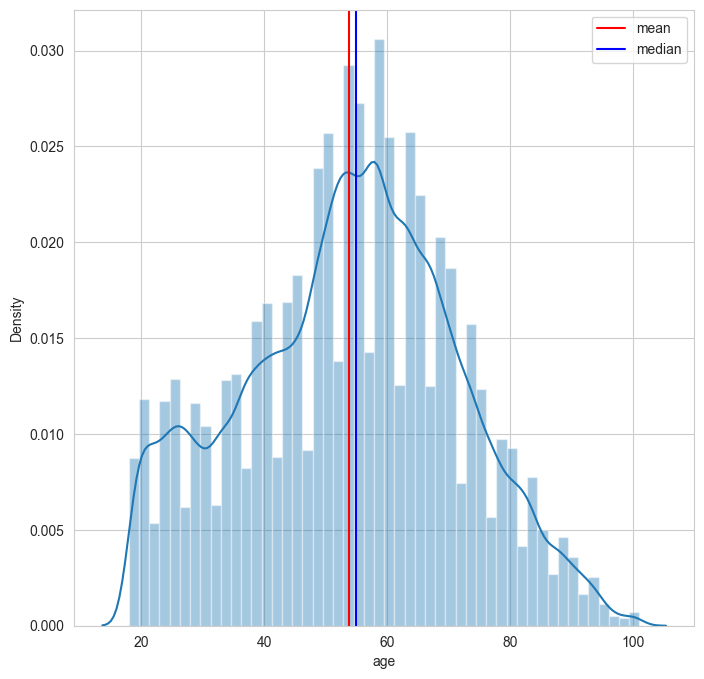

In [613]:
plot_distplot(df, 'age')

_we can see that there are total 84 different ages,**so perform data binning on them.**_

In [614]:
age_bins = [0,10,20,30,40,50,60,70,80,90,100,110]
age_labels = [1,2,3,4,5,6,7,8,9,10,11]
df['binned_age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [615]:
del df['age']

In [616]:
df.head(2)

,gender,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age
0,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6
1,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6


In [617]:
from datetime import datetime
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [618]:
df['date'] = df['became_member_on'].apply(convert_to_datetime)

In [619]:
df.head()

,gender,customer_id,became_member_on,income,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,date
0,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,2017-07-15
1,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,2017-07-15
2,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,2017-07-15
3,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,2017-07-15
4,0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,2017-07-15


In [620]:
del df['became_member_on']

In [621]:
df['income'].describe()

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64

_**Binning income**_

C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


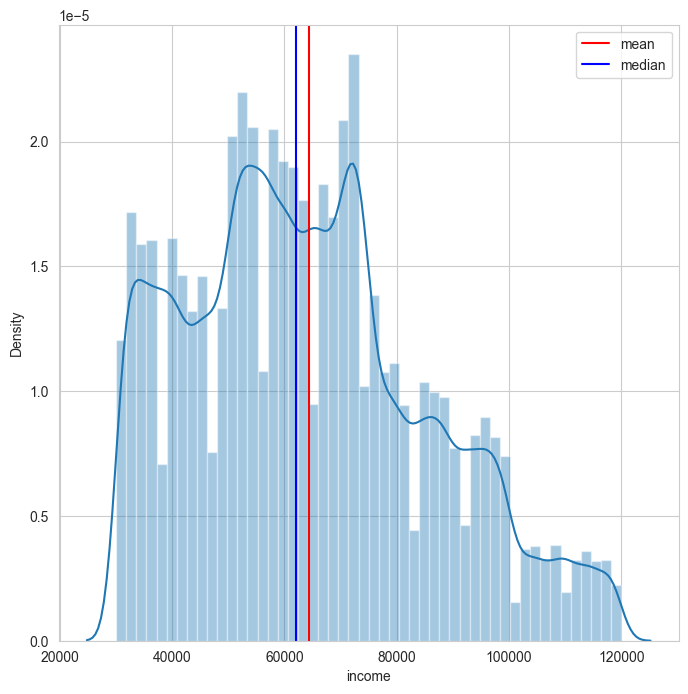

In [622]:
plot_distplot(df, 'income')

In [623]:
income_bins = [10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000]
income_labels = [2,3,4,5,6,7,8,9,10,11,12,13]
df['binned_income'] = pd.cut(df['income'], bins=income_bins, labels=income_labels)

In [624]:
del df['income']

In [625]:
df.time.describe()

count    272762.000000
mean        366.707694
std         200.359087
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


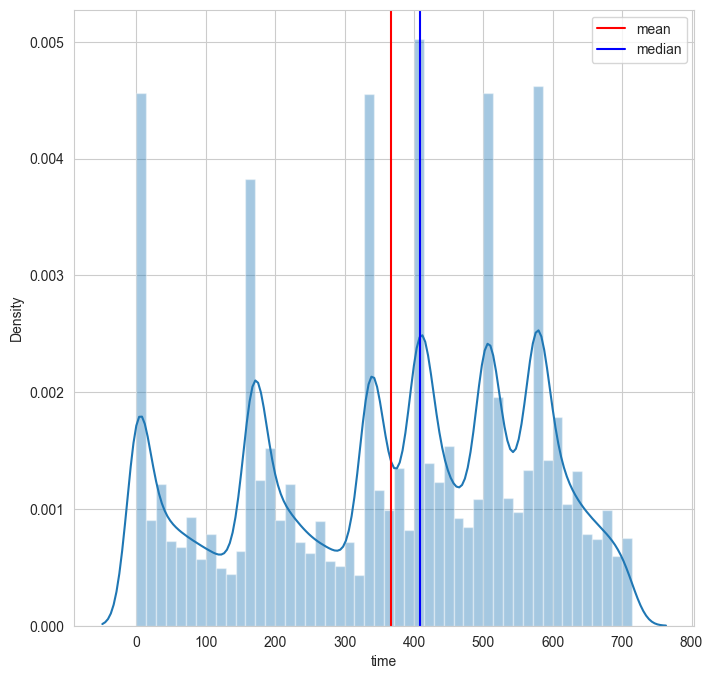

In [626]:
plot_distplot(df, 'time')

In [627]:
check_null(df)

gender has 0.0 % of null values
customer_id has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values
respond_to_offer has 0.0 % of null values
binned_age has 0.0 % of null values
date has 0.0 % of null values
binned_income has 0.0 % of null values


In [628]:
df.amount.describe()

count    272762.000000
mean          6.360646
std          22.509207
min           0.000000
25%           0.000000
50%           0.000000
75%           9.140000
max        1062.280000
Name: amount, dtype: float64

C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


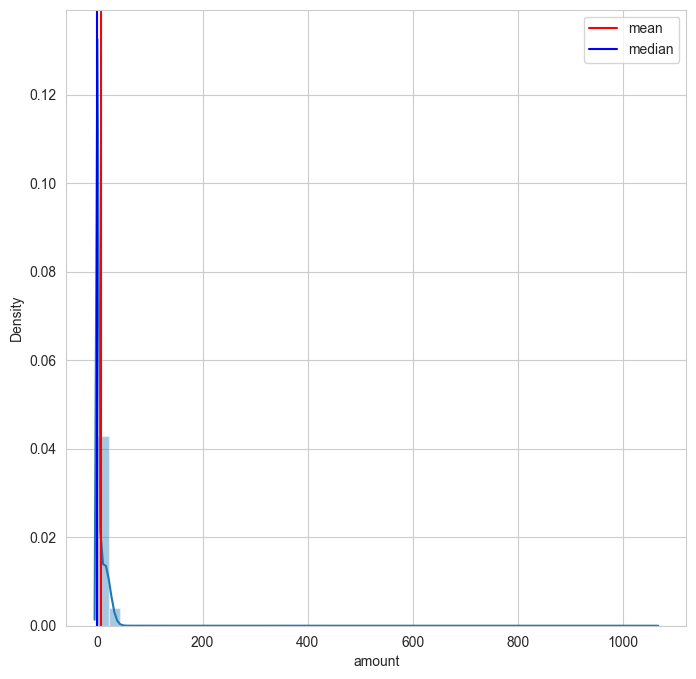

In [629]:
plot_distplot(df,'amount')

In [630]:
q = df["amount"].quantile(0.99)

In [631]:
df = df[df["amount"] < q]

In [632]:
df.shape

(270033, 18)

In [633]:
df.amount.describe()

count    270033.000000
mean          5.311545
std           8.421955
min           0.000000
25%           0.000000
50%           0.000000
75%           8.580000
max          35.340000
Name: amount, dtype: float64

C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


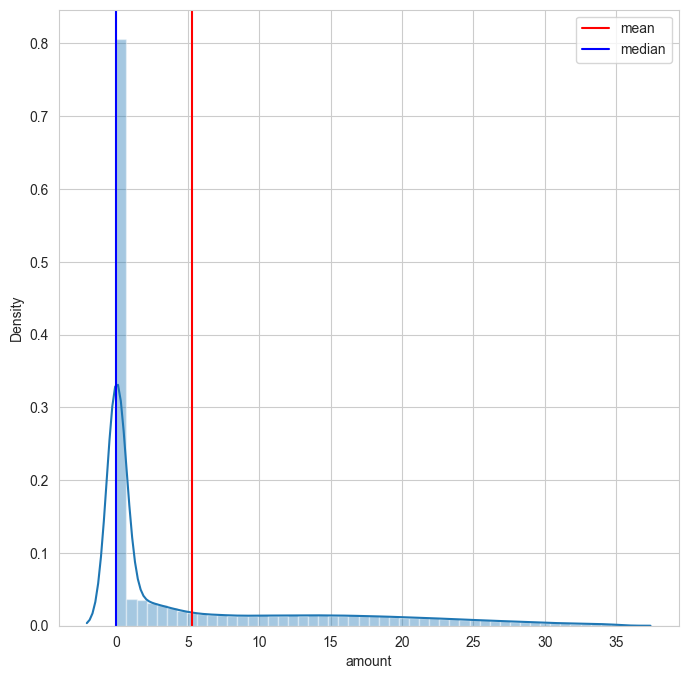

In [634]:
plot_distplot(df, 'amount')

In [635]:
check_null(df)

gender has 0.0 % of null values
customer_id has 0.0 % of null values
event has 0.0 % of null values
time has 0.0 % of null values
amount has 0.0 % of null values
offer_id has 0.0 % of null values
offer_type has 0.0 % of null values
duration has 0.0 % of null values
difficulty has 0.0 % of null values
reward has 0.0 % of null values
email has 0.0 % of null values
mobile has 0.0 % of null values
social has 0.0 % of null values
web has 0.0 % of null values
respond_to_offer has 0.0 % of null values
binned_age has 0.0 % of null values
date has 0.0 % of null values
binned_income has 0.0 % of null values


In [636]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,date,binned_income
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,2017-07-15,12
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,2017-07-15,12
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12


In [637]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [638]:
df['month'] = pd.DatetimeIndex(df['date']).month

In [639]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,date,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,2017-07-15,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,2017-07-15,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,2017-07-15,12,2017,7


In [640]:
del df['date']

_**To classify new customer wheter he/she will respond to offer or not, we will not have event, time and amount for new customer. So dropping these for training the model**_


In [641]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


**Saving dataframe**

In [642]:
df.to_csv('clean.csv', encoding='utf-8', index=False)

## 3. Exploratory Data Analysis

### A. Univariate Analysis

#### a. Distplot
**To get frequency distributions**

In [643]:
quant_columns = ['time', 'amount']
mapped_columns = ['gender', 'event', 'offer_id', 'offer_type']

In [644]:
non_mapped_columns = ['duration', 'difficulty', 'reward', 'email', 'mobile', 'social', 'web',
                      'binned_age', 'binned_income', 'year', 'month', 'respond_to_offer']

C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  mean = scipy.mean(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:3: DeprecationWarning: scipy.median is deprecated and will be removed in SciPy 2.0.0, use numpy.median instead
  median = scipy.median(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
C:\Users\sisaurav\AppData\Local\Temp\ipykernel_47268\3372511346.py:2: DeprecationWarning: scipy.mean is depre

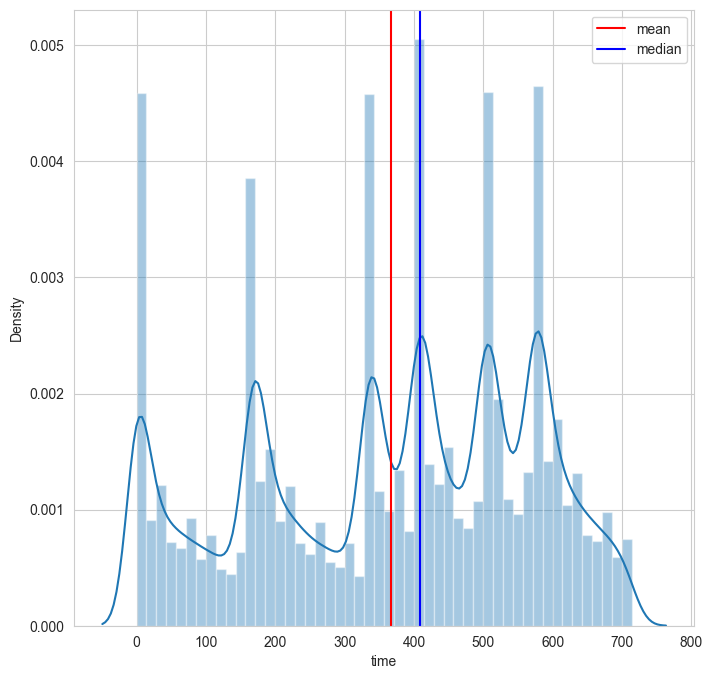

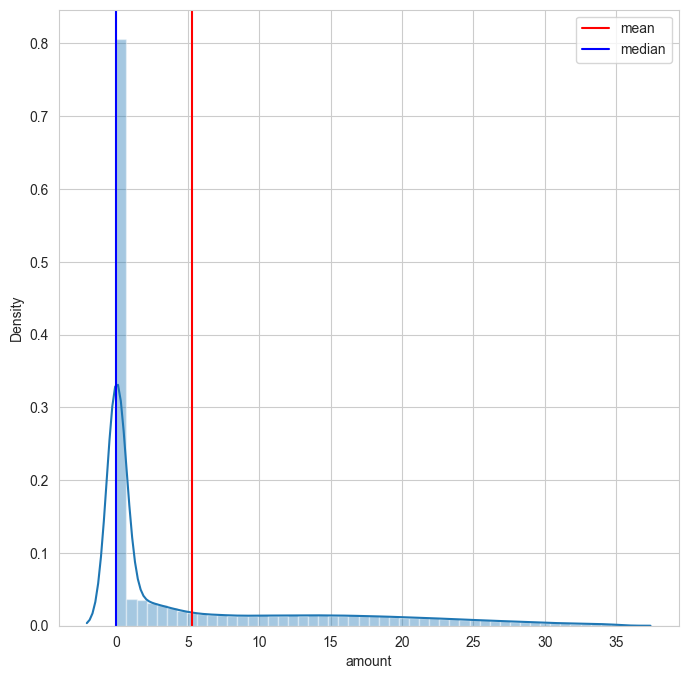

In [645]:
for col in quant_columns:
    plot_distplot(df, col)

_from graph we can see that Amount is having some Outliner._

#### b. Bar Plot

In [646]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
import numpy as np
import pandas as pd

In [647]:
def count_plot_legend(df, col, mapping):
    class TextHandler(HandlerBase):
        def create_artists(self, legend, tup ,xdescent, ydescent,
                            width, height, fontsize,trans):
            tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                      ha="center", va="center", color=tup[1], fontweight="bold")
            return [tx]



    base_color = sns.color_palette()[0]
    ax = sns.countplot(x = df[col], color= base_color)


    handltext = list(mapping.values())
    handltext = list(map(str, handltext))
    labels = list(mapping.keys())


    t = ax.get_xticklabels()
    labeldic = dict(zip(handltext, labels))
    labels = [labeldic[h.get_text()]  for h in t]
    handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]

    ax.legend(handles, labels, handler_map={tuple : TextHandler()}) 

    plt.show()

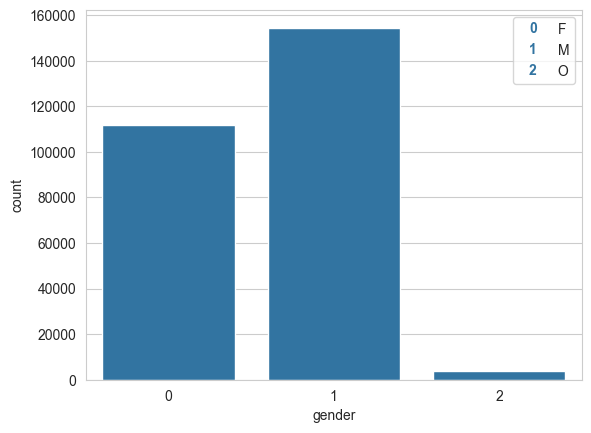

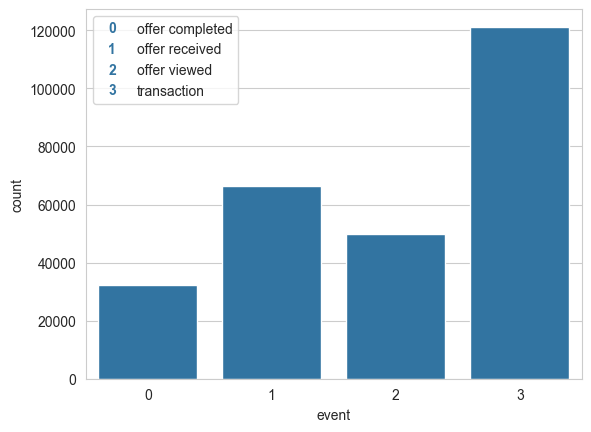

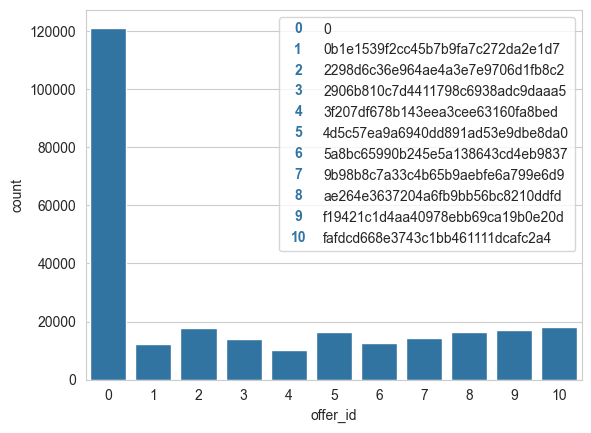

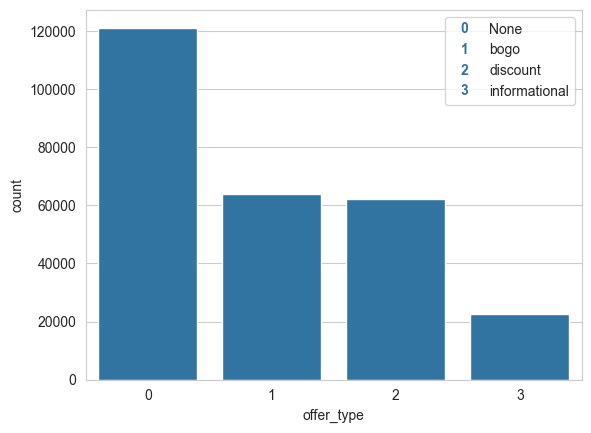

In [648]:
for col in mapped_columns:
    m = col + '_mapping'
    mapping = globals()[m]
    count_plot_legend(df,col ,mapping)

_from the above graphs we can conclude that Female are using less app than Male, also very few have opted for offer and most of app user are not getting offers._


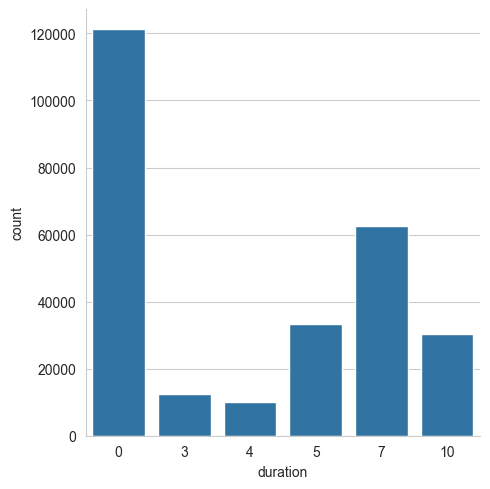

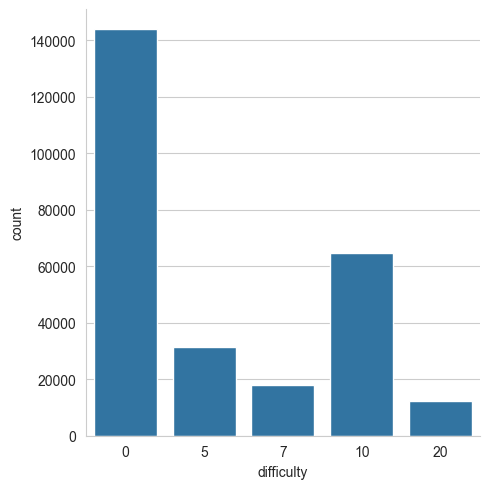

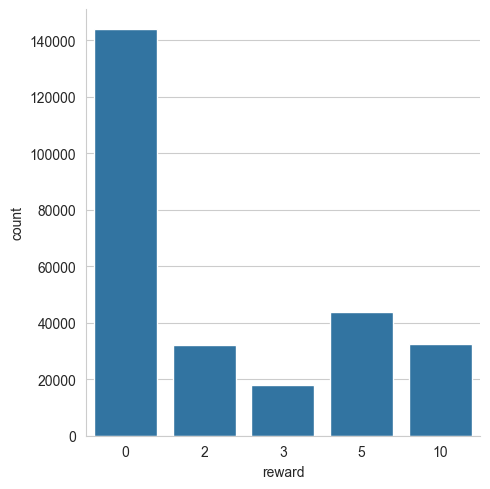

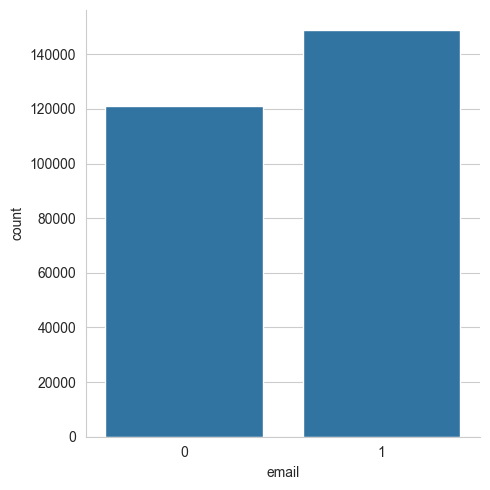

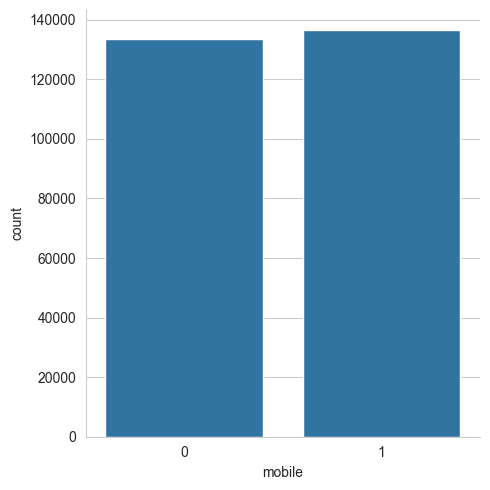

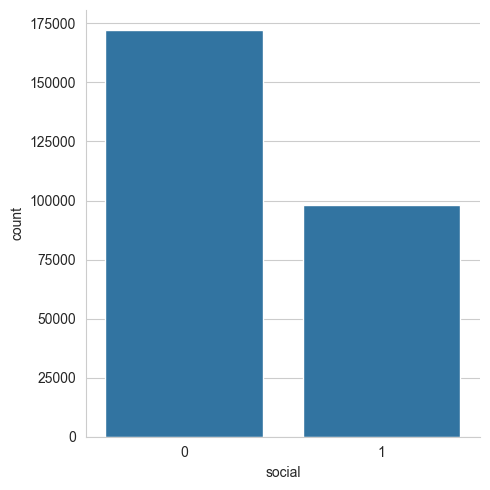

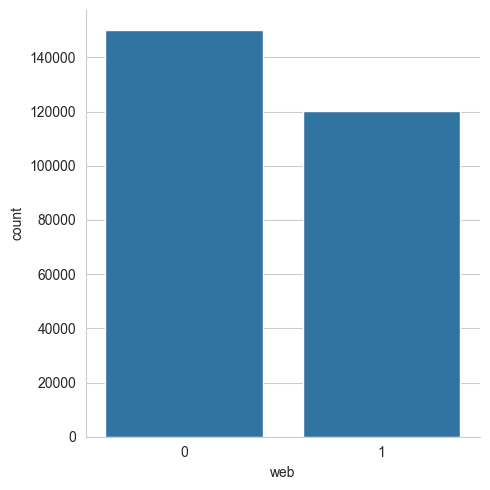

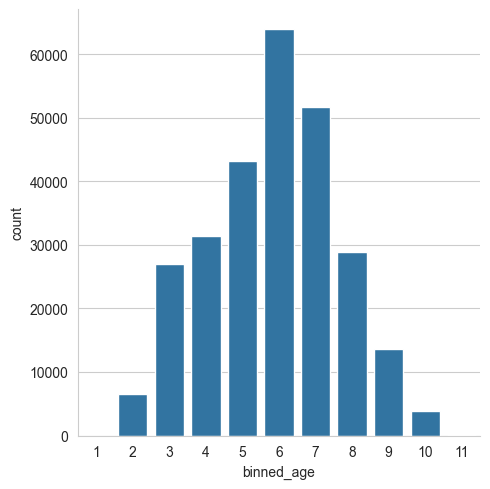

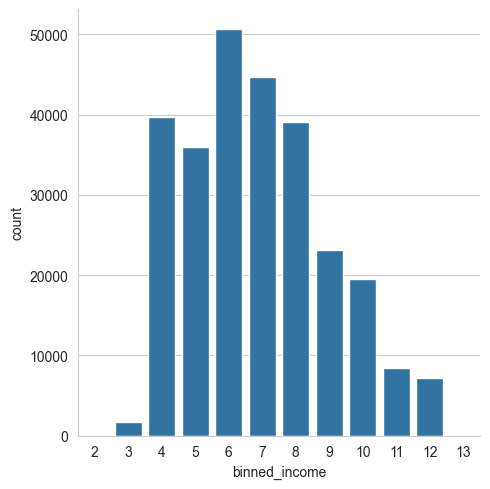

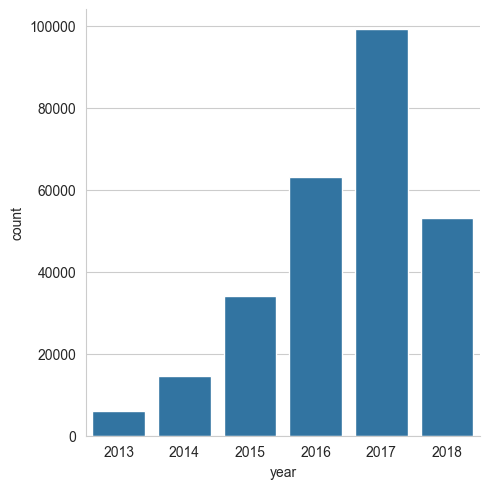

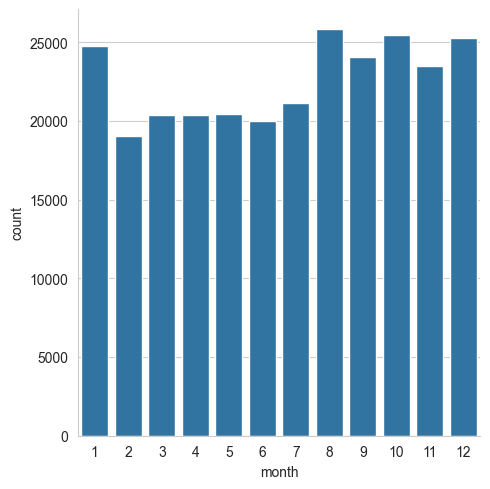

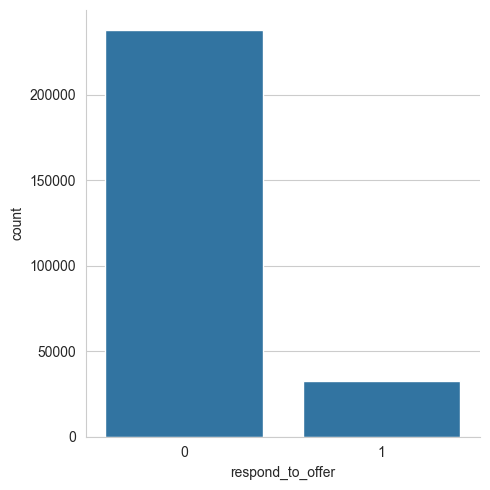

In [649]:
for col in non_mapped_columns:
    base_color = sns.color_palette()[0]
    sns.catplot(x=col, kind="count", color= base_color, data=df)

_From the graph we can see that very few people responded to offer and completes the offer._


### B. Bivariate/Multivariate Analysis

In [650]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


#### a. Countplot

gender  respond_to_offer
0       0                    96143
        1                    15477
1       0                   137997
        1                    16466
2       0                     3449
        1                      501
dtype: int64
***********************
event  respond_to_offer
0      1                    32444
1      0                    66501
2      0                    49860
3      0                   121228
dtype: int64
***********************
offer_id  respond_to_offer
0         0                   121228
1         0                     8941
          1                     3386
2         0                    13034
          1                     4886
3         0                    10091
          1                     3911
4         0                    10144
5         0                    12922
          1                     3310
6         0                    12516
7         0                    10184
          1                     4188
8         0            

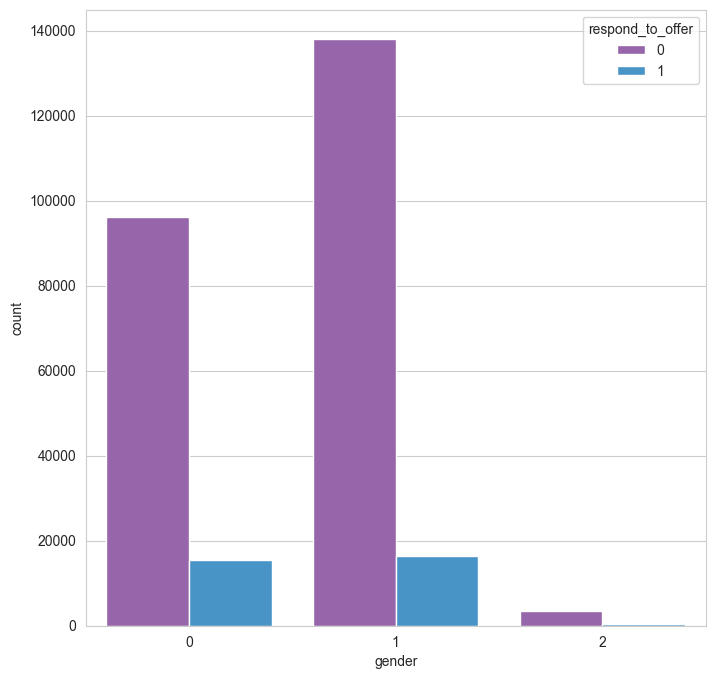

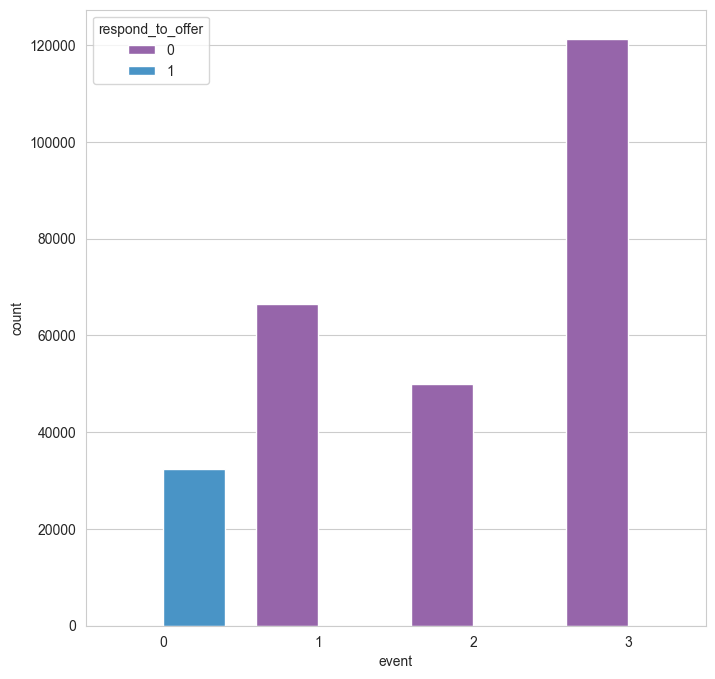

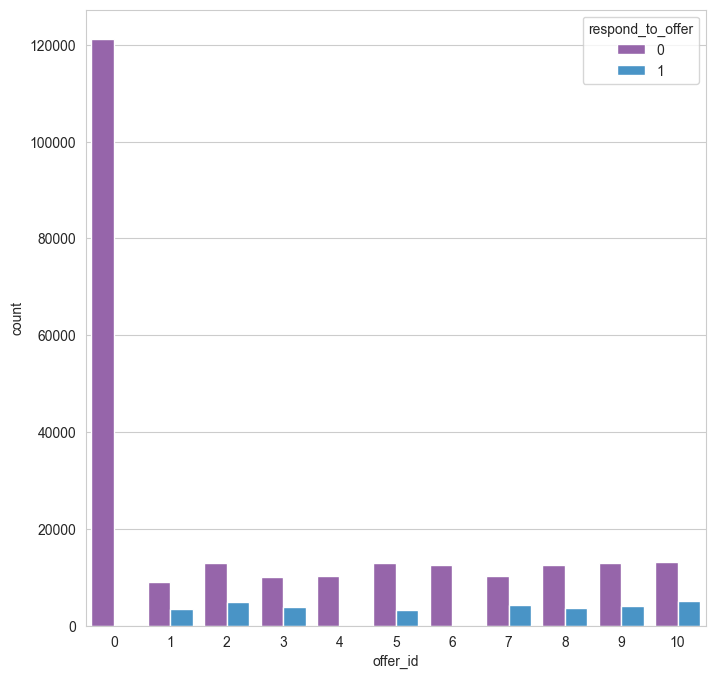

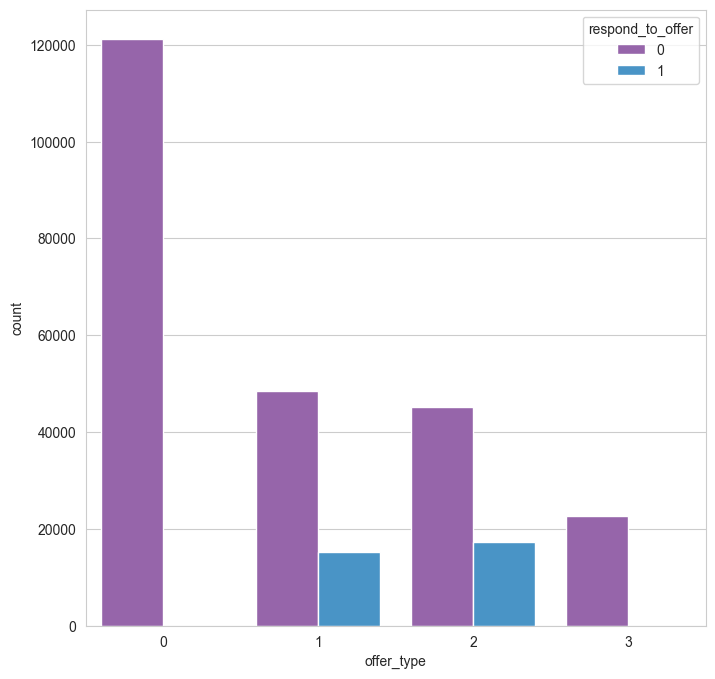

In [651]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for var in mapped_columns:
    temp = df.groupby([var,'respond_to_offer']).size()
    print(temp)
    print('***********************')
    plt.figure(figsize=(8,8))
    sns.countplot(data=df,x=var,hue='respond_to_offer', palette=flatui)

duration  respond_to_offer
0         0                   121228
3         0                    12516
4         0                    10144
5         0                    25808
          1                     7413
7         0                    45893
          1                    16642
10        0                    22000
          1                     8389
dtype: int64
***********************
difficulty  respond_to_offer
0           0                   143888
5           0                    23070
            1                     8291
7           0                    13034
            1                     4886
10          0                    48656
            1                    15881
20          0                     8941
            1                     3386
dtype: int64
***********************
reward  respond_to_offer
0       0                   143888
2       0                    23150
        1                     8914
3       0                    13034
        1            

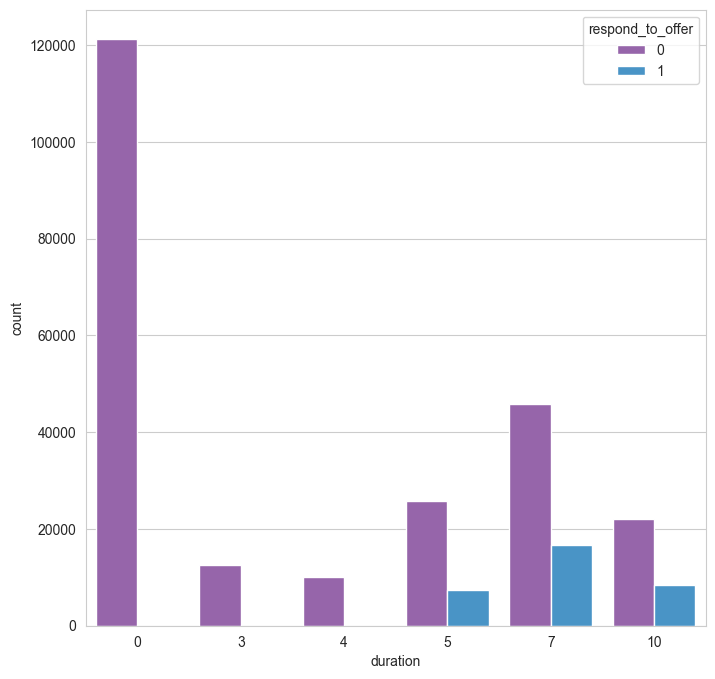

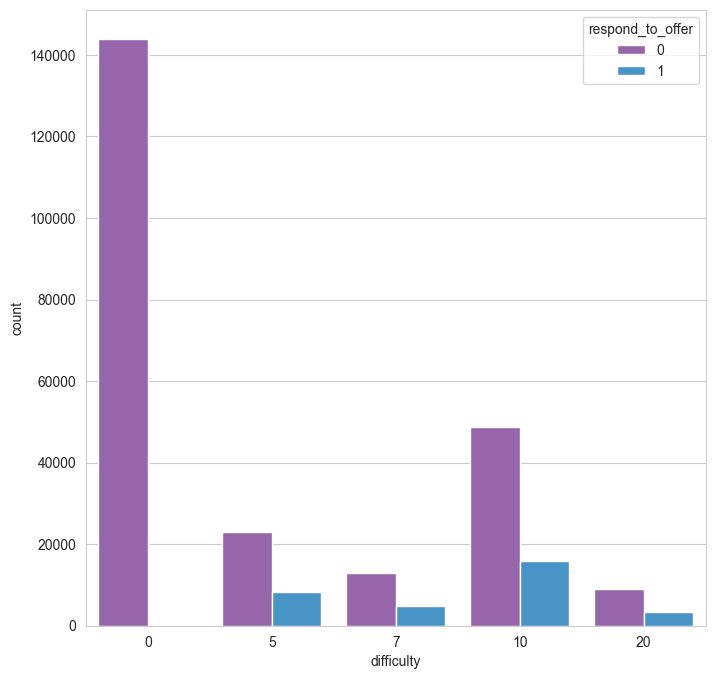

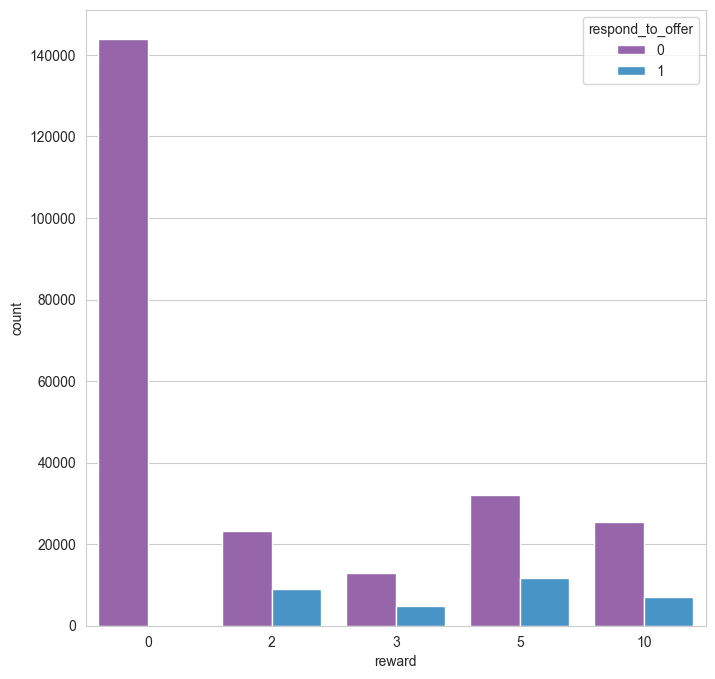

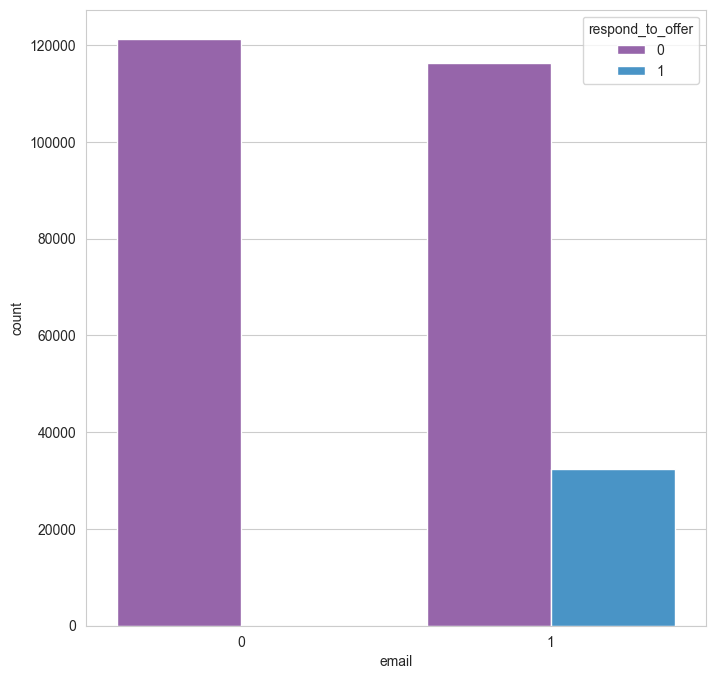

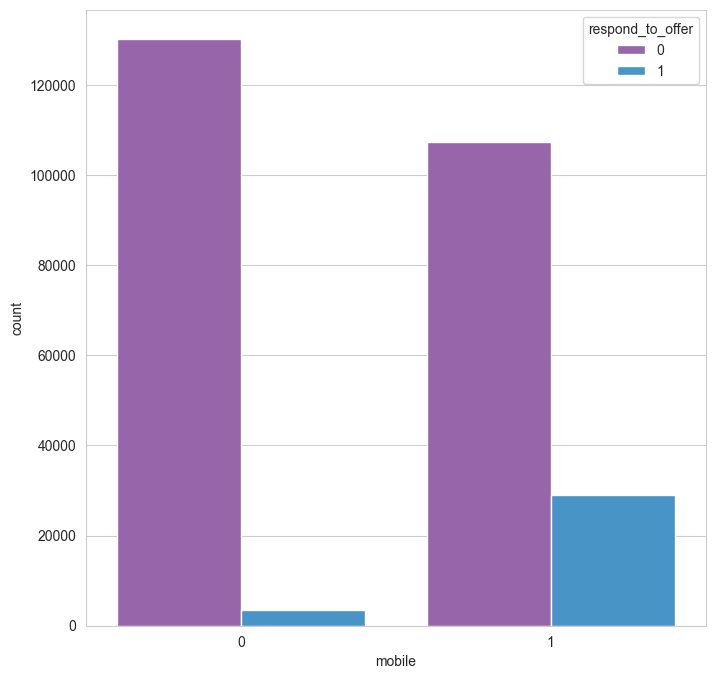

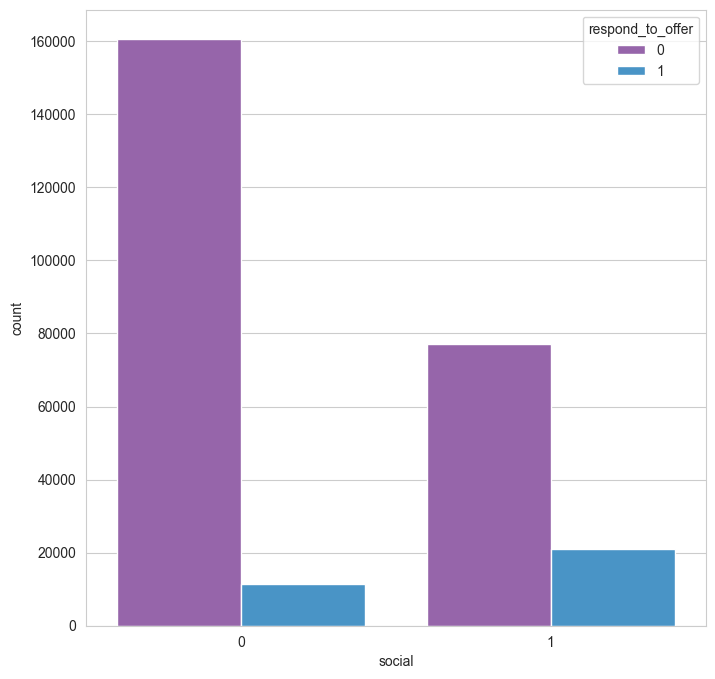

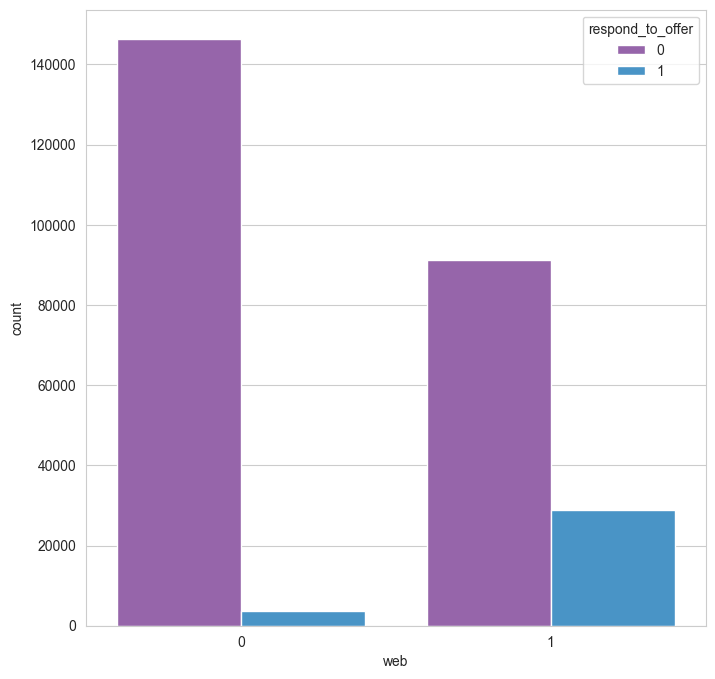

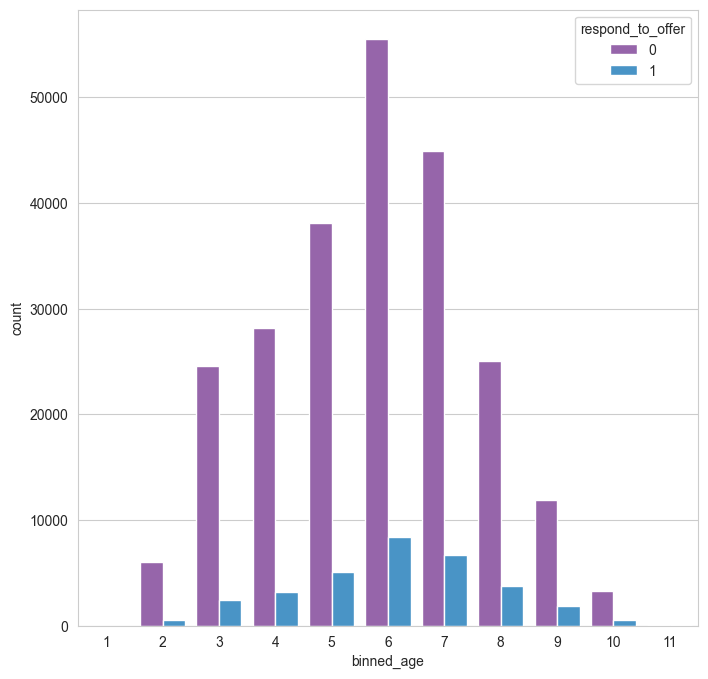

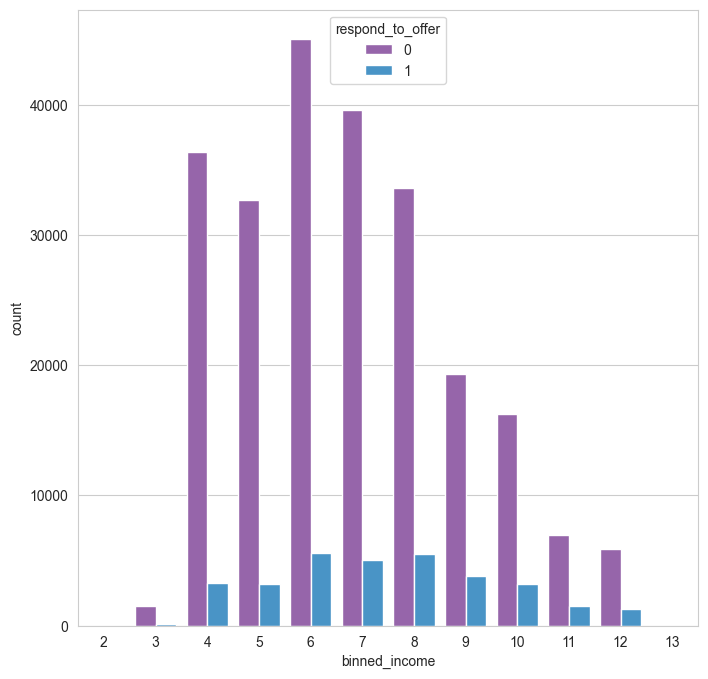

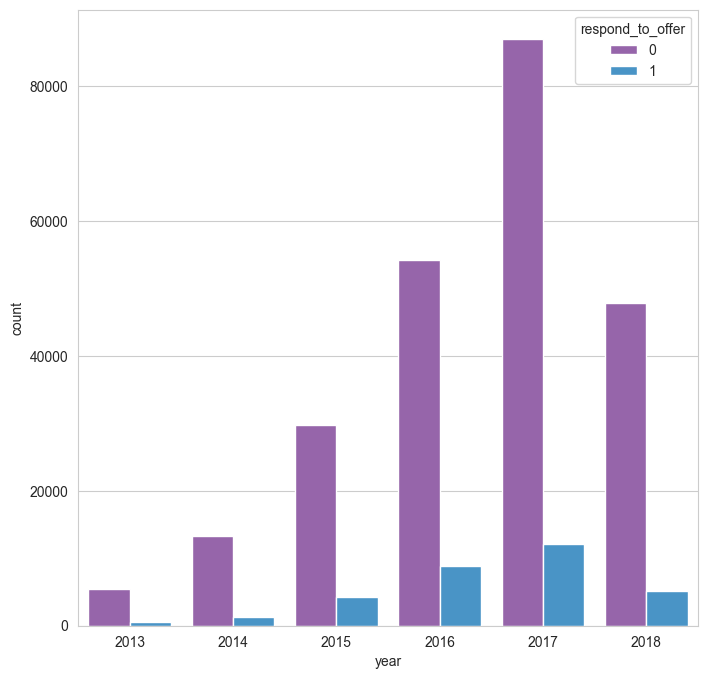

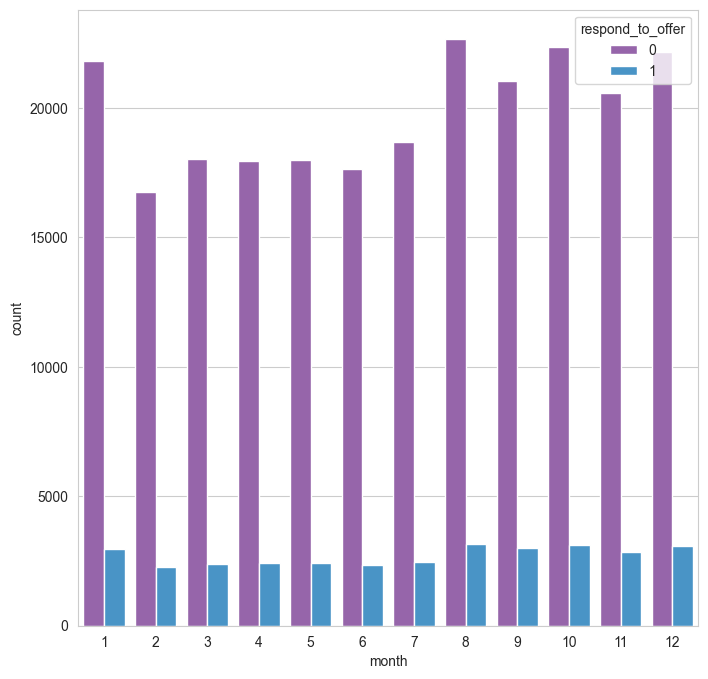

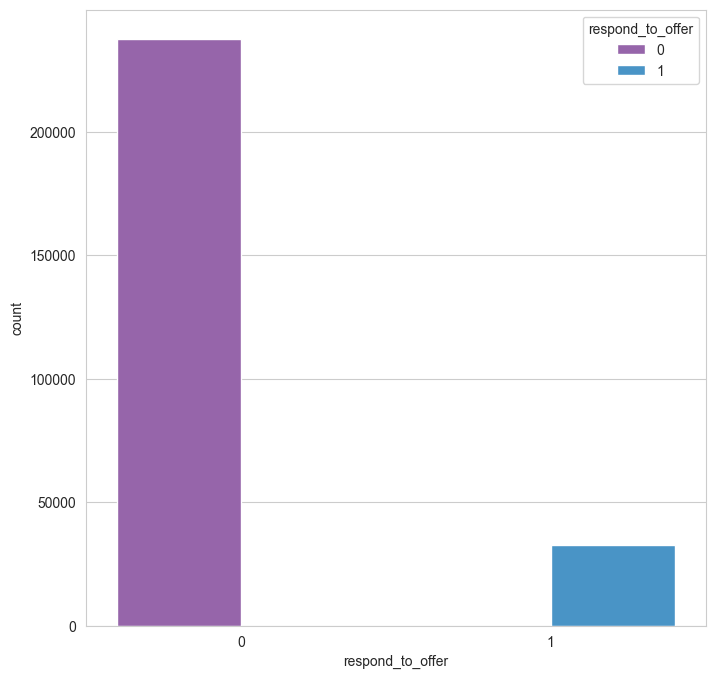

In [652]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for var in non_mapped_columns:
    temp = df.groupby([var,'respond_to_offer']).size()
    print(temp)
    print('***********************')
    plt.figure(figsize=(8,8))
    sns.countplot(data=df,x=var,hue='respond_to_offer', palette=flatui)

#### b. Boxplot

<AxesSubplot:xlabel='gender', ylabel='amount'>

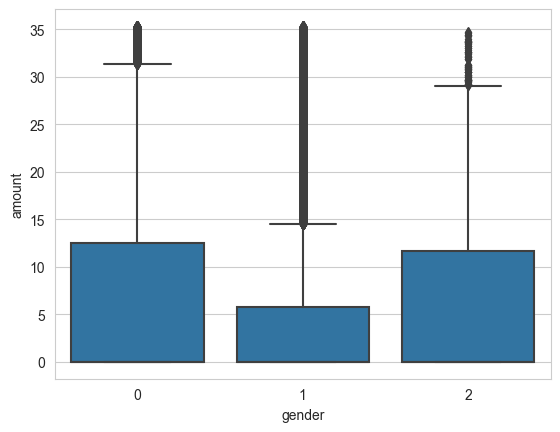

In [653]:
base_color = sns.color_palette()[0]
sns.boxplot(data = df, x = 'gender', y = 'amount', color = base_color)

<AxesSubplot:xlabel='gender', ylabel='time'>

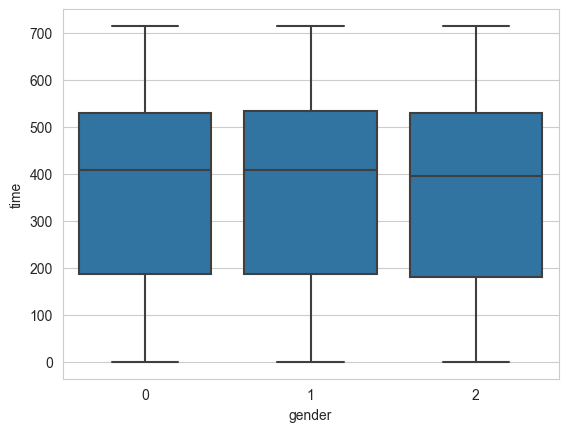

In [654]:
sns.boxplot(data = df, x = 'gender', y = 'time', color = base_color)

<AxesSubplot:xlabel='binned_age', ylabel='amount'>

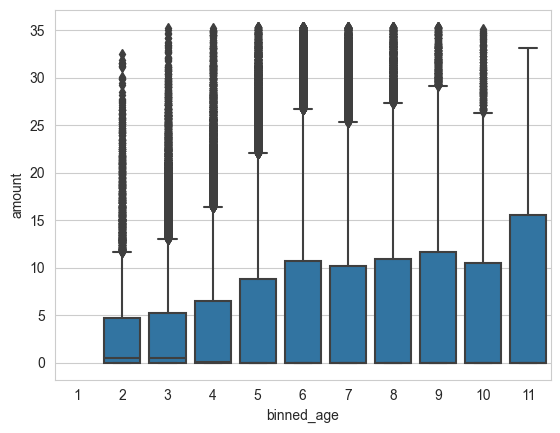

In [655]:
sns.boxplot(data = df, x = 'binned_age', y = 'amount', color = base_color)

<AxesSubplot:xlabel='binned_age', ylabel='time'>

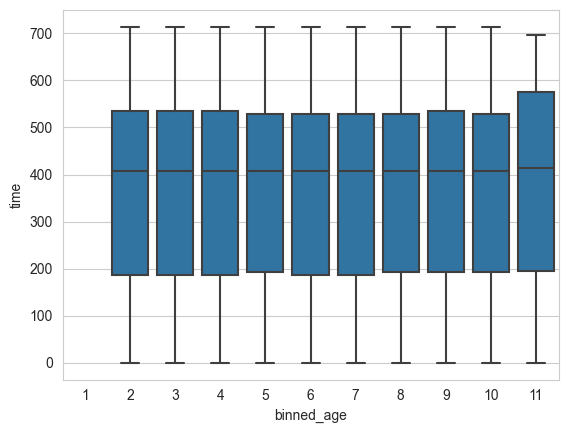

In [656]:
sns.boxplot(data = df, x = 'binned_age', y = 'time', color = base_color)

<AxesSubplot:xlabel='binned_income', ylabel='amount'>

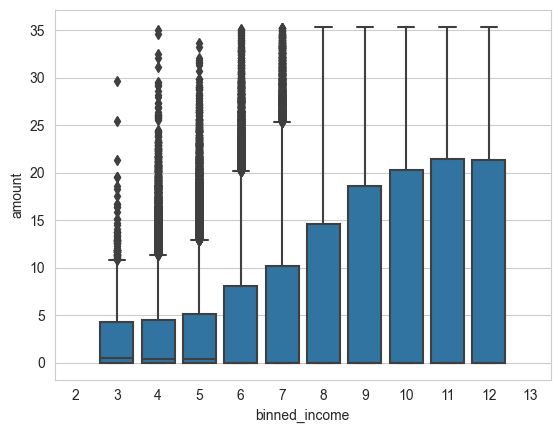

In [657]:
sns.boxplot(data = df, x = 'binned_income', y = 'amount', color = base_color)

<AxesSubplot:xlabel='binned_income', ylabel='time'>

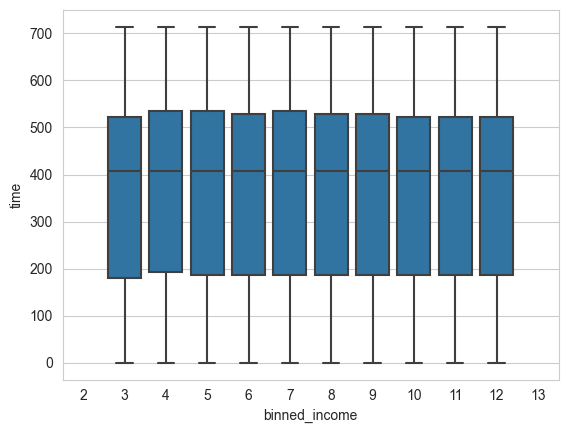

In [658]:
sns.boxplot(data = df, x = 'binned_income', y = 'time', color = base_color)

#### c. Correlation

In [659]:
df.corr()

,gender,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,year,month
gender,1.000000,0.041506,-0.000333,-0.099056,-0.022194,-0.022679,-0.029616,-0.028675,-0.027317,-0.031526,-0.026295,-0.017041,-0.027766,-0.044792,-0.035653,-0.028184
event,0.041506,1.000000,0.032084,0.603873,-0.673984,-0.710949,-0.813719,-0.676273,-0.588906,-0.864230,-0.770675,-0.554622,-0.730546,-0.669160,-0.074058,-0.000399
time,-0.000333,0.032084,1.000000,0.044751,-0.057567,-0.060442,-0.051374,-0.035947,-0.040740,-0.065994,-0.064838,-0.051850,-0.046818,0.061083,-0.008791,0.006440
amount,-0.099056,0.603873,0.044751,1.000000,-0.554300,-0.595121,-0.629805,-0.505690,-0.462386,-0.698741,-0.637544,-0.475857,-0.564238,-0.233057,-0.032324,0.015708
offer_id,-0.022194,-0.673984,-0.057567,-0.554300,1.000000,0.559242,0.717161,0.457330,0.590526,0.793284,0.843968,0.744903,0.556301,0.269081,0.083947,-0.001443
offer_type,-0.022679,-0.710949,-0.060442,-0.595121,0.559242,1.000000,0.738001,0.510097,0.234521,0.851705,0.752007,0.504715,0.656419,0.212993,0.093781,-0.001815
duration,-0.029616,-0.813719,-0.051374,-0.629805,0.717161,0.738001,1.000000,0.881506,0.610564,0.901343,0.738119,0.559889,0.807923,0.370733,0.092345,-0.003043
difficulty,-0.028675,-0.676273,-0.035947,-0.505690,0.457330,0.510097,0.881506,1.000000,0.696823,0.723716,0.456446,0.411589,0.673043,0.338392,0.073441,-0.003407
reward,-0.027317,-0.588906,-0.040740,-0.462386,0.590526,0.234521,0.610564,0.696823,1.000000,0.661742,0.588539,0.599159,0.457007,0.276694,0.070858,-0.003056
email,-0.031526,-0.864230,-0.065994,-0.698741,0.793284,0.851705,0.901343,0.723716,0.661742,1.000000,0.912418,0.681021,0.807507,0.333539,0.107174,-0.002566


<AxesSubplot:>

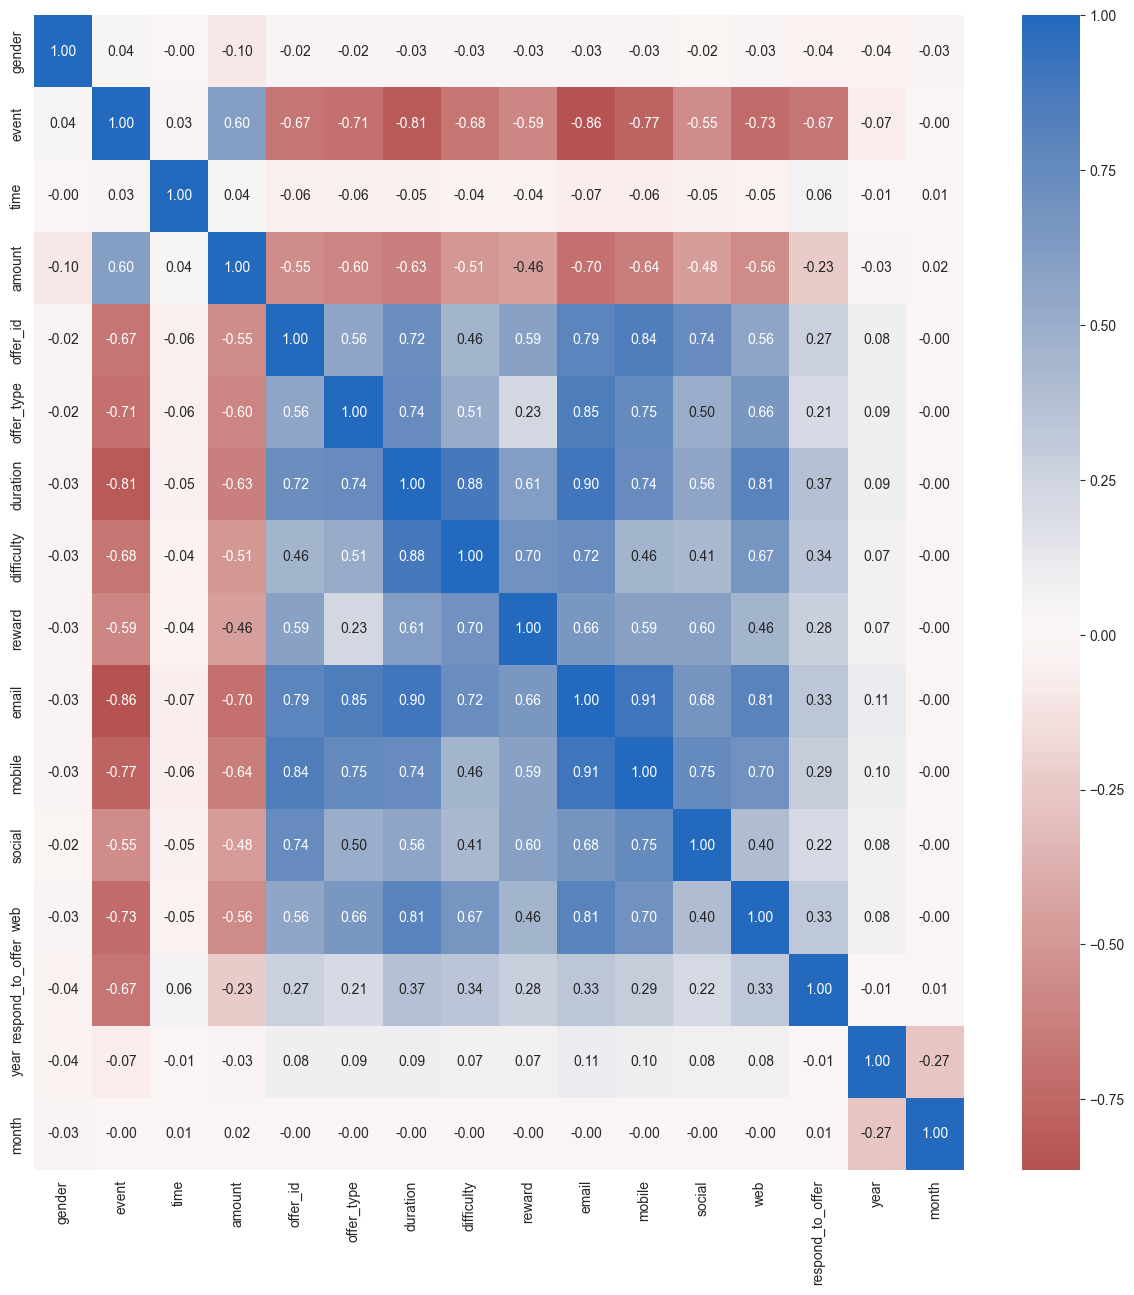

In [660]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)

**Conclusion for Response to Offer:**

_1. Event is highly negatively correlated with response_to_offer._<br>
_2. duration, difficulty, reward, email, moobile, social and web are slightly positively correlated with response_to_offer._


 

In [661]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


## 4. Explanatory Data Analysis


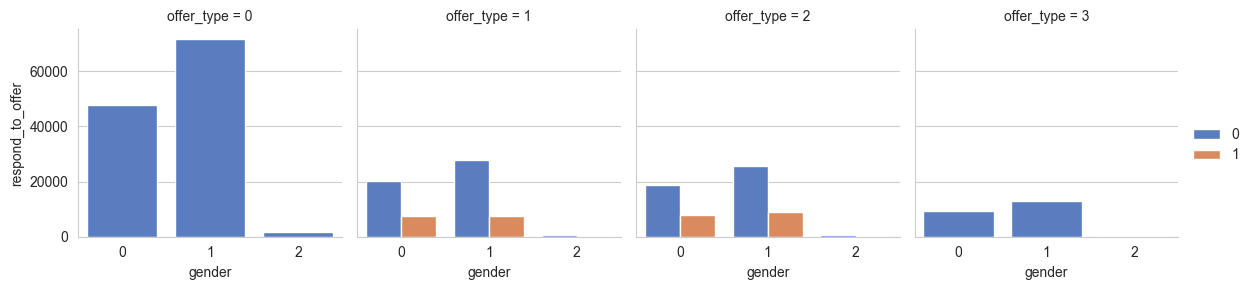

In [662]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

grid = sns.FacetGrid(data=df,col='offer_type',aspect=1)
fig = grid.map(countplot,'gender','respond_to_offer',palette='muted')
fig.add_legend()

In [663]:
gender_mapping

{'F': 0, 'M': 1, 'O': 2}

In [664]:
offer_type_mapping

{'None': 0, 'bogo': 1, 'discount': 2, 'informational': 3}

_**from the graph we can see that both Male and female are completed the offer but mostly offer type 'BOGO' and 'discount'.**_

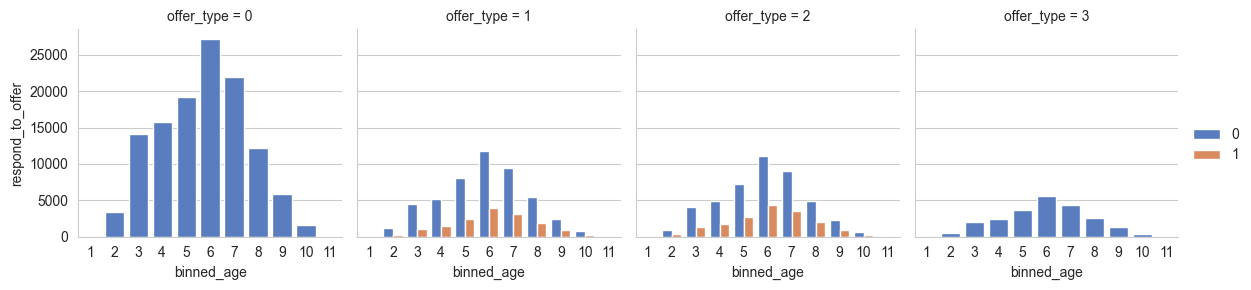

In [665]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

grid = sns.FacetGrid(data=df,col='offer_type',aspect=1)
fig = grid.map(countplot,'binned_age','respond_to_offer',palette='muted')
fig.add_legend()

**Conclusion:**
_1. People of all ages respond almost equally to 'BOGO' and 'Discount'_<br>
_2. People of age 50-60 complete the offer - Discount most_,<br>
_3. Then People of age 60-70 complete the offer - Discount most_<br>
_4. Offer Type BOGO and Discount has almost similar distribution of response across different age groups._


 

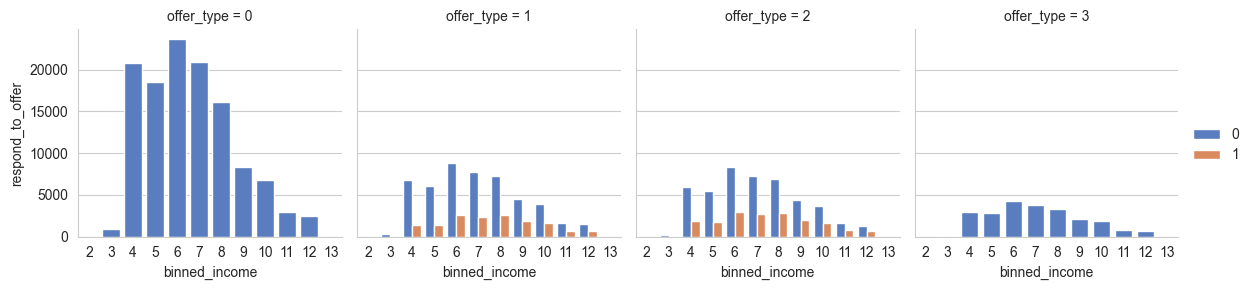

In [666]:
def countplot(x, hue, **kwargs):
    sns.countplot(x=x, hue=hue, **kwargs)

grid = sns.FacetGrid(data=df,col='offer_type',aspect=1)
fig = grid.map(countplot,'binned_income','respond_to_offer',palette='muted')
fig.add_legend()

In [667]:
print(*income_bins)

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000


_From graph we can see that people with income between 60000 and 80000 spend most on offer type 'BOGO' and 'Discount'._


<AxesSubplot:xlabel='binned_age', ylabel='count'>

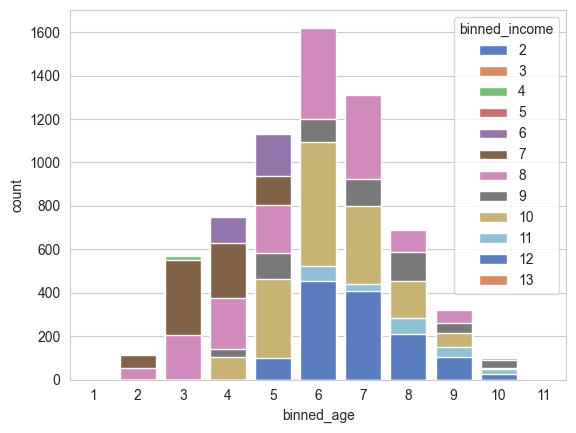

In [668]:
sns.countplot(data=df[df['respond_to_offer']==1],x='binned_age', hue= 'binned_income', palette='muted', dodge=False)

_People of age 50-70 of income between 60000-90000 respond most to offers type 'BOGO' and 'Discount'_
Conclusion : **So it will be good to send BOGO and Discount offers to these people**

## 5. Model Building

In [669]:
df.head()

,gender,customer_id,event,time,amount,offer_id,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income,year,month
0,0,0610b486422d4921ae7d2bf64640c50b,3,18,21.51,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
1,0,0610b486422d4921ae7d2bf64640c50b,3,144,32.28,0,0,0,0,0,0,0,0,0,0,6,12,2017,7
2,0,0610b486422d4921ae7d2bf64640c50b,1,408,0.00,7,1,7,5,5,1,1,0,1,0,6,12,2017,7
3,0,0610b486422d4921ae7d2bf64640c50b,1,504,0.00,4,3,4,0,0,1,1,0,1,0,6,12,2017,7
4,0,0610b486422d4921ae7d2bf64640c50b,3,528,23.22,0,0,0,0,0,0,0,0,0,0,6,12,2017,7


_Drop customer_id and offer_id values_<br>
_As time and amount will be unknown for new customer so we can drop_ <br>
_Drop year and month as they are not correlate much with respond_to_offer_

In [670]:
df.drop(['customer_id', 'offer_id', 'time', 'amount', 'year', 'month'], axis=1, inplace=True)

In [671]:
df.head()

,gender,event,offer_type,duration,difficulty,reward,email,mobile,social,web,respond_to_offer,binned_age,binned_income
0,0,3,0,0,0,0,0,0,0,0,0,6,12
1,0,3,0,0,0,0,0,0,0,0,0,6,12
2,0,1,1,7,5,5,1,1,0,1,0,6,12
3,0,1,3,4,0,0,1,1,0,1,0,6,12
4,0,3,0,0,0,0,0,0,0,0,0,6,12


In [672]:
df.to_csv('final.csv', encoding='utf-8', index=False)

In [673]:
y = df['respond_to_offer']
X = df.drop('respond_to_offer', axis=1)


In [674]:
X.shape

(270033, 12)

In [675]:
y.shape

(270033,)

In [676]:
from sklearn.model_selection import train_test_split
# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [677]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
classifier = RandomForestClassifier()

In [678]:
# training
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [679]:
# predictions
y_pred = classifier.predict(X_test)

In [680]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [681]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')

=== Confusion Matrix ===
[[78484     0]
 [    0 10627]]




In [682]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78484
           1       1.00      1.00      1.00     10627

    accuracy                           1.00     89111
   macro avg       1.00      1.00      1.00     89111
weighted avg       1.00      1.00      1.00     89111





## 6. Hyperparameter Tuning


In [683]:
rfc = RandomForestClassifier()

In [684]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [10,50,100,500,1000]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

In [685]:
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid,
                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [686]:
# Fit the model
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\sisaurav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [100, 140, 180, 220, 260,
                                                      300, 340, 380, 420, 460,
                                                      500, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 50, 100, 500,
                                                         1000]},
                   random_state=42, verbose=2)

In [687]:
print(rfc_random.best_params_)

{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 260}


Training Random Forest on best parameters

In [688]:
model = RandomForestClassifier(n_estimators=1000, max_depth=260, max_features='auto')

In [689]:
model.fit(X_train,y_train)

C:\Users\sisaurav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=260, max_features='auto', n_estimators=1000)

In [690]:
y_pred_final = model.predict(X_test)

In [691]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_final))

=== Confusion Matrix ===
[[78484     0]
 [    0 10627]]


In [692]:
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_final))

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78484
           1       1.00      1.00      1.00     10627

    accuracy                           1.00     89111
   macro avg       1.00      1.00      1.00     89111
weighted avg       1.00      1.00      1.00     89111



## 7. Final conclusion to Problem statment

while working on dataset provided for this project, we found that
_1. Male and Female almost equally complete the offer. So offers should be sent equally among them._ <br>
_2. The two most completed offer type are 'BOGO' and 'Discount'. So these two should be sent to more people._<br>
_3. People of age 50–70 of income between 60000–90000 respond most to offers type 'BOGO' and 'Discount'. So it will be good to send BOGO and Discount offers to these people._<br>


During analysis we have used Model Random Forest Classifier with hyperparameter tuning to predict whether a customer will complete an offer by making transaction after viewing the offer with the accuracy of 1. I may be getting an accuracy of 1 due to considering only the most important features and dropping all unnecessary features.


In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert','--to','html','Starbucks_Capstone_notebook.ipynb'])

0